In [31]:
# For this notebook to work, you need a huggingface account to download the weights for the model
# additionally, you'll need pytorch and a cuda enabled gpu with at least 10gb of ram, not counting vram for os and programs
# it is not reccomended to run this on the same machine you are streaming from

# output will overwite a stream.png image and stream.txt that you can point obs to

In [4]:
# # can comment this block out after first run
# !pip install --upgrade diffusers transformers scipy
# !huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
        
Login successful
Your token has been saved to C:\Users\Alex/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your termin

In [1]:
# download model / load into ram
import socket, re, time
from emoji import demojize
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
from simpleutils import *

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, use_auth_token=True)
pipe = pipe.to(device)

In [12]:
output_folder_name = 'streamable_output'

# pipeline options
save_all_images = True # if true, saves each individual image with prompt as name in the output folder
save_grid = True       # if true, saves the final grid with prompt as name in output folder
# if false, will still overwrite the stream image

update_as_generated = True # if generating a grid, will update stream image one by one as 

batch_columns = False # batching columns will generate each row faster, but at much higher vram


disable_safety_checker = False
safety_adjustment = 0.01
blank_nsfw = False


global_args = {"pipe": pipe,
               "save_all_images": save_all_images,
               "save_grid": save_grid,
               "update_as_generated": update_as_generated,
               "batch_columns": batch_columns,
               "output_folder_name": output_folder_name,
               "disable_safety_checker": disable_safety_checker,
               "safety_adjustment": safety_adjustment,
               "blank_nsfw": blank_nsfw}

"no mans sky concept art" - StableDiffusion v1.4


  0%|          | 0/51 [00:00<?, ?it/s]

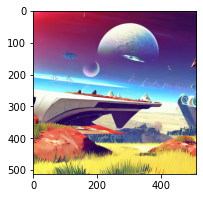

  0%|          | 0/51 [00:00<?, ?it/s]

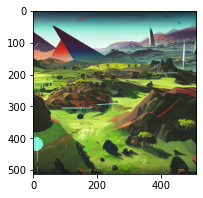

  0%|          | 0/51 [00:00<?, ?it/s]

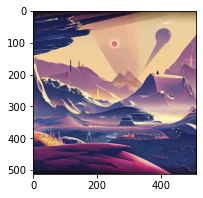

  0%|          | 0/51 [00:00<?, ?it/s]

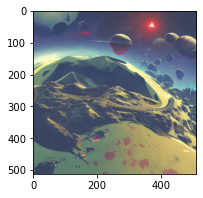

"no mans sky concept art" - StableDiffusion v1.4


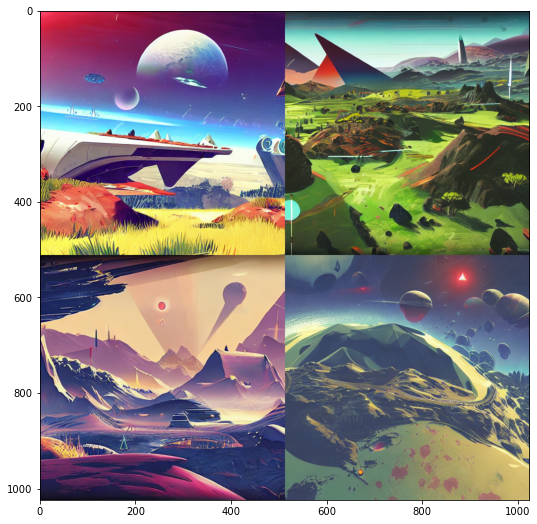

In [18]:
# # example standalone call
generate_images("no mans sky concept art",
                steps=50, 
                guidance=7.5, 
                grid_size=(2, 2), 
                seed=None,
               **global_args)

In [4]:
# based in part on
# https://github.com/LearnDataSci/articles/tree/master/How%20to%20Stream%20Text%20Data%20from%20Twitch%20with%20Sockets%20in%20Python

In [8]:
# simple way to get oauth token is via https://twitchapps.com/tmi/ 
# however a more 'proper route would handle authorization itself'
# may have to update token every few months

# should probably change this to load from a txt config
# should also probably stop testing in production buuuuut *shrug*
server = 'irc.chat.twitch.tv'
port = 6667
nickname = '********'
token = 'oauth:*******************************'
channel = '#*********'

In [11]:
# could use GET https://api.twitch.tv/helix/users/follows?to_id=<user ID>
# or something along those lines to check for followers

textfile = os.getcwd()+ '\\'+ output_folder_name +'\\stream\\' + 'stream' + '.txt'
def apply_command(msg, user):    
    if msg[:9] == '!generate':
        # do checks for flags, steps, guidance, hw,
        prompt = msg[9:]
        print('found generate command!, prompt:', prompt)
        with open(textfile, 'w') as f:
            f.write("generating new images...")
        generate_images(prompt, steps=50, guidance=8.0, grid_size=(2, 2), seed=None)
        with open(textfile, 'w') as f:
            f.write("requested by: "+user)
            
    elif msg[:5] == '!del' or msg[:6] == '!clear':
        print('found delete command!, updating to blank image..')
        blank_image = Image.new('RGBA', size=(512, 512))
        save_image(blank_image, os.getcwd()+ '\\'+ output_folder_name +'\\' + 'stream' + '.png', overwrite=True)
        with open(textfile, 'w') as f:
            f.write("")
        
    elif (msg[:8] == '!approve' or msg[:4] == '!app') and user == nickname:
        print('found approve command!, displaying full grid regardless of filtering..')
        with Image.open(os.getcwd() + '\\' + output_folder_name + '\\stream\\' + 'stream_unf' + '.jpg') as im:
            save_image(im, os.getcwd() + '\\' + output_folder_name + '\\stream\\' + 'stream' + '.jpg', overwrite=True)
    elif msg[:10] == '!terminate' and user == nickname:
        return True
    
    else:
        print(msg, 'command not found')
    return False
        
    
    # todo: add commands for deleting, selecting from grid, regenerate same prompt, possibly check user privs
    # possibly some sort of saved queue, allowing for !previous !next type thing to scroll through
    # or default to slideshow after a period of time

In [ ]:
sock = socket.socket()
sock.connect((server, port))
sock.settimeout(1.0)

sock.send(f"PASS {token}\n".encode('utf-8'))
sock.send(f"NICK {nickname}\n".encode('utf-8'))
sock.send(f"JOIN {channel}\n".encode('utf-8'))

while True:
    try:
        resp = sock.recv(2048).decode('utf-8')
        print(resp)

        if resp.startswith('PING'):
            sock.send("PONG\n".encode('utf-8'))
            print('ponged server ping')

        elif len(resp) > 0:
            last_msg = demojize(resp)
            attempt_msg_deconstruct = re.search(':(.*)\!.*@.*\.tmi\.twitch\.tv PRIVMSG #(.*) :(.*)', last_msg)
            if attempt_msg_deconstruct is not None:
                user, chl, msg = attempt_msg_deconstruct.groups()
                print(user) # , ':', msg)
                if msg[0] == '!':
                    error = apply_command(msg, user)
                    if error: 
                        apply_command('!clear', nickname)
                        break
    except socket.timeout:
        continue # probs should do something here
    except ConnectionAbortedError:
        continue # probs should do something here
    except KeyboardInterrupt:
        print('closing connection...')
        sock.close()
        break
print('closing connection...')
sock.close()